In [169]:
# Import necessary libraries
from Bio import SeqIO
import pandas as pd
import numpy as np
import sys
if "helpers" in sys.modules:
    del sys.modules["helpers"]
import helpers
import os
import re
import matplotlib.pyplot as plt

In [ ]:
# Eliminate duplicates from a FASTA file using CD-HIT
# os.system("cd-hit -i ../Data/00-raw/2025-04-14_IPR001919.fasta -o ../Data/01-unique/IPR001919_unique.fa -c 1")

Program: CD-HIT, V4.8.1, Aug 07 2022, 07:05:53
Command: cd-hit -i ../Data/00-raw/2025-04-14_IPR001919.fasta
         -o ./Test.fasta -c 1

Started: Sat May 17 23:21:57 2025
                            Output                              
----------------------------------------------------------------
total seq: 26436
longest and shortest : 8505 and 33
Total letters: 14520842
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 18M
Buffer          : 1 X 18M = 18M
Table           : 1 X 65M = 65M
Miscellaneous   : 0M
Total           : 102M

Table limit with the given memory limit:
Max number of representatives: 1007492
Max number of word counting entries: 87211732

comparing sequences from          0  to      26436
..........    10000  finished       9578  clusters
..........    20000  finished      19315  clusters
......
    26436  finished      25466  clusters

Approximated maximum memory consumption: 211M
writing new database
writing clustering inform

0

## Read InterPro data

In [3]:
# Read the InterPro fasta file
ipfastafile = '../Data/01-unique/IPR001919_unique.fa'
ip_recs = list(SeqIO.parse(ipfastafile, "fasta"))
print(f"Number of records in {ipfastafile}: {len(ip_recs)}")
# Read the InterPro tsv file
iptsvfile = '../Data/00-raw/2025-04-14_IPR001919.tsv'
ip_df = pd.read_csv(iptsvfile, sep="\t", header=0)
print(f"Number of records in {iptsvfile}: {len(ip_df)}")


Number of records in ../Data/01-unique/IPR001919_unique.fa: 25466
Number of records in ../Data/00-raw/2025-04-14_IPR001919.tsv: 26436


In [6]:
# Make a new column with the range of CBM2 in a different format
ip_df['CBM2'] = ip_df.Matches.apply(lambda x: "+".join(x.replace("..", "-").split(",")))
# Rename the 'Accession' column to 'uniprot'
ip_df = ip_df.rename(columns={'Accession': 'uniprot'})
# Save file for use in structure analysis
ip_df.to_csv("../Data/06-structure_analysis/CBM2_interpro_ranges.tsv", sep="\t", index=False)

## Extract CBM2 sequences

## MMH motif
### Find in sequence

In [68]:
# Read the full sequences from the InterPro dataset ()
recs = list(SeqIO.parse("../Data/02-extract/extracted_CBM2_mg.fa", "fasta"))
print(f"number of sequences read: {len(recs)}")

number of sequences read: 26310


In [69]:
# Define the motif MXnMXH pattern using regular expressions
motif_pattern = re.compile("M.*M.H")

# Iterate over the sequences and search for the motif
matches = []

for seq_record in recs:
    sequence = str(seq_record.seq)
    if motif_pattern.search(sequence):
        matches.append(seq_record)

# Write the sequences with the motif to a new file
#SeqIO.write(matches, "../Data/03-find_motifs/CBM2_MMH.fa", "fasta")
print(f"number of sequences with the motif: {len(matches)}")
print(f"sequences with the motif written to: ../Data/03-find_motifs/CBM2_MMH.fa")


number of sequences with the motif: 713
sequences with the motif written to: ../Data/03-find_motifs/CBM2_MMH.fa


In [70]:
# extract the uniprot id from the sequence ID
uniprot_ids = [seq_record.id.split("|")[0] for seq_record in matches]
# Check if the ids are unique
print(f'{len(set(uniprot_ids))} out of {len(uniprot_ids)} ids are unique')
# write the uniprot ids to a file
# with open("uniprot_ids.txt", "w") as f:
#     f.write("\n".join(uniprot_ids))
print(f"uniprot ids written to: uniprot_ids.txt")

713 out of 713 ids are unique
uniprot ids written to: uniprot_ids.txt


In [71]:
# Read the full sequences from the original dataset
recs_full = list(SeqIO.parse("../Data/00-raw/2025-04-14_IPR001919.fasta", "fasta"))
print(f"number of sequences read: {len(recs_full)}")
# retrieve only the sequences with the motif
matches_full = []
for seq_record in recs_full:
    if seq_record.id.split("|")[0] in uniprot_ids:
        matches_full.append(seq_record)
print(f"number of sequences with the motif: {len(matches_full)}")
# Write the sequences with the motif to a new file
# SeqIO.write(matches_full, "fullseqs_MMH.fa", "fasta")


number of sequences read: 26436
number of sequences with the motif: 713


### Confirm MMH in structures

In [7]:
# Read the uniprot ids from the MMH-containing sequences
with open("../Data/03-find_motifs/uniprot_ids.txt", "r") as f:
    uniprot_ids = f.read().splitlines()
# Read the interpro 
ip_df = pd.read_csv("../Data/06-structure_analysis/CBM2_interpro_ranges.tsv", sep="\t", index_col=0)

In [72]:
# Make a function for checking if there is an MMH motif in the structure
def check_mmh(structure, cbm2_ranges, thres=8.5):
    # Keep only the CA atoms and set the index to the residue number
    structure = structure[structure.atom_name == "CA"].set_index('residue')
    for cbm2_range in cbm2_ranges:
        # Get the start and end positions of the range
        start, end = map(int, cbm2_range.split("-"))
        # Get the cbm2 structure
        cbm2_structure = structure.loc[start:end]
        # Get the coordinates of the alpha carbons of Met and His
        met_his_coords = cbm2_structure[cbm2_structure.amino_acid.isin(['MET', 'HIS'])]
        # Get distance matrix
        distance_matrix = helpers.get_distance_matrix(met_his_coords)
        # Check if there is a His with a Met in the position i-2 and another Met within 8 Å
        for his in met_his_coords[met_his_coords.amino_acid == 'HIS'].itertuples():
            his_index = his.Index
            # Check if the residue i-2 is a Met
            if his_index-2 <= start:
                continue
            if not cbm2_structure.loc[his_index-2].amino_acid == 'MET':
                continue
            # Check if there are at least two Met within the distance threshold
            mask = distance_matrix[his_index].between(1,thres)
            mm_distances = distance_matrix.loc[mask,mask]
            if not mm_distances.shape[0] >= 2:
                continue
            # Check if at least two of these Met residues are also within the distance threshold
            if ((mm_distances > 1) & (mm_distances < thres)).any().any():
                return True
        return False


In [73]:
pdb_dir = "../Data/05-structures/"
pdbs = [f for f in os.listdir(pdb_dir) if f.endswith(".pdb")]
thres = 8.5  # max distance in Ångstrøms between M-M-H
mmh_results = pd.DataFrame(columns=['structure_mmh'])
pdb_not_found = []
for accession in uniprot_ids:
    try:
        pdb = [p for p in pdbs if accession in p][0]
    except IndexError:
        pdb_not_found.append(accession)
        continue
    pdb_file = os.path.join("../Data/05-structures/", pdb)
    structure = helpers.read_pdb(pdb_file)
    cbm2_ranges = ip_df.loc[accession, 'CBM2'].split("+")
    try:
        mmh_results.loc[accession] = check_mmh(structure, cbm2_ranges, thres=thres)
    except Exception as e:
        print(f'acession {accession}, Ex {e}')

/Users/estebanlopeztavera/anaconda3/envs/grl39/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 12058
  warnings.warn(
/Users/estebanlopeztavera/anaconda3/envs/grl39/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 7196
  warnings.warn(


In [74]:
print(f"number of structures not found: {len(pdb_not_found)}")
# from the pdbs that were analyzed, check the results
print(mmh_results.value_counts())

number of structures not found: 0
structure_mmh
True             685
False             28
Name: count, dtype: int64


In [33]:
# Get list of the sequences with the MMH motif not meeting the structure criteria (considered false positives)
no_mmh_struc = mmh_results[~mmh_results.structure_mmh].index.to_list()
# Get the sequences with the MMH motif meeting the structure criteria (true MMH), and include the ones missing structure files
mmh_struc = mmh_results[mmh_results.structure_mmh].index.to_list() + pdb_not_found
# Save the list to a file
with open("../Data/03-find_motifs/MMH_struc_validated_ids.txt", "w") as f:
    f.write("\n".join(mmh_struc))

## Annotated domains in DBCAN
The 713 sequences matching the MMH pattern were annotated using the dbCAN3 server (https://bcb.unl.edu/dbCAN2/blastation.php?jobid=2025042433759)

In [30]:
# Read table
import pandas as pd 
dbcan_df = pd.read_csv("../Data/04-DBcan/MMH_dbcan.tsv", sep="\t")
print(dbcan_df.shape[0])
# Add uniprot column
dbcan_df['uniprot'] = dbcan_df['Gene ID'].apply(lambda x: x.split("|")[0])

709


In [31]:
# Check which sequences are not in the DBcan table
dbcan_ids = dbcan_df["uniprot"].to_list()
print(f"number of sequences in the DBcan table: {len(dbcan_ids)}")

ids_not_in_dbcan = [i for i in uniprot_ids if i not in dbcan_ids]
print(f"number of sequences not in the DBcan table: {len(ids_not_in_dbcan)}")
print(ids_not_in_dbcan)

number of sequences in the DBcan table: 709
number of sequences not in the DBcan table: 4
['A0A1G4SCK8', 'A0A1H2UGA1', 'A0A8G1MZR7', 'A0A919R3Z2']


In [40]:
# Check which of these don't have a structure-verified MMH
print(f'Not annotated by DBcan but lacking a verified MMH: {[i for i in ids_not_in_dbcan if i in no_mmh_struc]}')

Not annotated by DBcan but lacking a verified MMH: ['A0A1G4SCK8', 'A0A1H2UGA1', 'A0A8G1MZR7']


Inspected manually A0A919R3Z2 in Pymol.
A0A919R3Z2 doesn’t have an MMH, but has an HMH motif that binds Cu in AF3 model.

In [35]:
# Check the domains present
dbcan_df['Domains'] = dbcan_df.HMMER.apply(lambda x: re.sub(r"\(.*?\)", "", x))
print(dbcan_df.Domains.value_counts())

Domains
AA10+CBM2              648
CBM2                    35
GH9                      7
N                        5
AA10                     4
GH10+CBM2                2
CBM2+CBM2                2
GH5_8+CBM2               1
AA10+CBM2+CBM2+GH18      1
GH5_1+CBM2               1
CBM2+GH5_2+CBM13         1
GH5_40                   1
CBM2+GH5_1               1
Name: count, dtype: int64


In [36]:
# Inspect the sequences matching the MMH motif that do not meet the MMH structure criteria
dbcan_df[dbcan_df.uniprot.isin(no_mmh_struc)]

,Gene ID,EC#,HMMER,dbCAN_sub,DIAMOND,Signalp,#ofTools,uniprot,Domains
65,A0A177HRM1|unreviewed|CBM2,1.14.99.54|1.14.99.53,CBM2(1-72),CBM2_e70,N,N,2,A0A177HRM1,CBM2
155,A0A1Z9B5K6|unreviewed|CBM2,-,AA10(38-218),AA10_e0,N,Y(1-38),2,A0A1Z9B5K6,AA10
186,A0A2P8I1Y2|unreviewed|Endoglucanase|taxID:1280637,3.2.1.78|-,GH5_8(39-293)+CBM2(438-538),GH5_e22+CBM2_e31,CBM2+GH5_8,Y(1-29),3,A0A2P8I1Y2,GH5_8+CBM2
224,A0A345T3H0|unreviewed|CBM2,1.14.99.54|1.14.99.53,AA10(35-219)+CBM2(258-351),AA10_e30+CBM2_e70,AA10+CBM2,Y(1-35),3,A0A345T3H0,AA10+CBM2
234,A0A3D0QQI1|unreviewed|Beta-xylanase|taxID:1931,3.2.1.8,GH10(50-344)+CBM2(367-458),GH10_e90+CBM2_e115,CBM2+GH10,Y(1-45),3,A0A3D0QQI1,GH10+CBM2
316,A0A5B9YDT5|unreviewed|CBM2,-,CBM2(123-206)+CBM2(229-323),CBM2_e59+CBM2_e59,CBM2,N,3,A0A5B9YDT5,CBM2+CBM2
444,A0A7Z0Q2K9|unreviewed|CBM2,-,CBM2(420-519),CBM2_e62,CBM2,Y(1-33),3,A0A7Z0Q2K9,CBM2
511,A0A964Q5W4|unreviewed|CBM2,-,CBM2(38-131)+CBM2(159-253),CBM2_e56+CBM2_e56+GH18_e337,CBM2+GH18,N,3,A0A964Q5W4,CBM2+CBM2
519,A0A9E5S1C5|unreviewed|Endoglucanase|taxID:2720413,3.2.1.4|-,GH5_1(62-379)+CBM2(455-550),GH5_e271+CBM2_e52,CBM2+GH5_1,N,3,A0A9E5S1C5,GH5_1+CBM2
538,A0AA90R2S6|unreviewed|cellulase|taxID:3057165,3.2.1.4|3.2.1.78|3.2.1.145|3.2.1.132|-,CBM2(97-186)+GH5_2(225-462)+CBM13(518-654),CBM2_e56+GH5_e251+CBM13_e360,N,N,2,A0AA90R2S6,CBM2+GH5_2+CBM13


In [75]:
# Drop the false positives from the DBcan table
dbcan_df = dbcan_df[~dbcan_df.uniprot.isin(no_mmh_struc)]
# Check the domains present
dbcan_df.Domains.value_counts().to_frame()

,count
Domains,
AA10+CBM2,646
CBM2,33
AA10,3
AA10+CBM2+CBM2+GH18,1
GH5_40,1


In [222]:
dbcan_df[dbcan_df.Domains.isin(["AA10+CBM2+CBM2+GH18", "GH5_40"])]

,Gene ID,EC#,HMMER,dbCAN_sub,DIAMOND,Signalp,#ofTools,CBM2,AA10,uniprot,Domains
510,A0A960BMZ2|unreviewed|chitinase|taxID:2900548,3.2.1.4|3.2.1.176|3.2.1.91|3.2.1.8|3.2.1.-|-,AA10(35-208)+CBM2(236-315)+CBM2(371-471)+GH18(...,AA10_e0+CBM2_e21+CBM2_e116+GH18_e427,CBM12+GH18,Y(1-35),3,236-315+371-471,35-208,A0A960BMZ2,AA10+CBM2+CBM2+GH18
563,A0AAU1AR00|unreviewed|CBM2,3.2.1.78,GH5_40(293-523),GH5_e171,CBM2+GH5_40,Y(1-29),3,,,A0AAU1AR00,GH5_40


Inspected those two structures manually in Pymol.
- A0AAU1AR00 is a false positive.
- A0A960BMZ2 doesn’t have an MMH, but has an HMH motif that binds Cu in AF3 model.


In [63]:
def get_domain_range(x, domain):
    """
    Get the range of a domain in a domain architecture string (HMMER column)
    """
    # split the string by +
    domains = x.split("+")
    # iterate over the domains
    rngs = []
    for d in domains:
        # check if the domain is in the string
        if domain in d:
            # get the range of the domain
            rng = d.split("(")[1].split(")")[0]
            rngs.append(rng)
    return rngs
# Get the range of the CBM2 domain
dbcan_df['CBM2'] = dbcan_df['HMMER'].apply(lambda x: '+'.join(get_domain_range(x, "CBM2")))
# Get the range of the AA10 domain
dbcan_df['AA10'] = dbcan_df['HMMER'].apply(lambda x: '+'.join(get_domain_range(x, "AA10")))

In [183]:
# Save the new table with the ranges
dbcan_df.to_csv("../Data/03-find_motifs/MMH_dbcan_ranges.tsv", sep="\t", index=False)

In [184]:
# Check the sequences that do not have AA10
MMH_noAA10_df = dbcan_df[~dbcan_df["HMMER"].str.contains("AA10")]
print(f"number of sequences without AA10: {MMH_noAA10_df.shape[0]}")


number of sequences without AA10: 34


In [ ]:
# Make list of accessions for sequences without AA10
accessions_MMH_noAA10 = MMH_noAA10_df["uniprot"].to_list()
# Include the sequences that are not in the DBcan table
accessions_MMH_noAA10 += ids_not_in_dbcan
# Save list of accessions to a file
with open("../Data/03-find_motifs/MMH_noAA10_ids.txt", "w") as f:
    f.write("\n".join(accessions_MMH_noAA10))

Manually inspected those structures in Pymol. They consist of either just a CBM2 starting with the first M of MMH, or a disordered tail with a CBM2.

## REF motif

In [64]:
# Read the dbcan table with domain ranges
dbcan_df = pd.read_csv("../Data/03-find_motifs/MMH_dbcan_ranges.tsv", sep="\t")

In [84]:
# Define the motif RXnEXF pattern using regular expressions
motif_pattern = re.compile(r'R.{3,10}E.F')

# Make a dataframe with the sequences that have a AA10 domain
dbcan_aa10_df = dbcan_df[(dbcan_df.AA10 != '') & ~dbcan_df.AA10.isna() & (dbcan_df.uniprot != 'A0A960BMZ2')]

def check_REF(row):
    """
    Check if the sequence has the REF motif
    """
    # Get the sequence
    sequence = [str(rec.seq) for rec in matches_full if rec.id.split("|")[0] == row.uniprot][0]
    # Get the range of the AA10 domain
    aa10_start, aa10_end = map(int, row.AA10.split("-"))
    # Check if the sequence has the REF motif
    sequence = sequence[aa10_start-1:aa10_end]
    if motif_pattern.search(sequence):
        return True
    else:
        return False

dbcan_aa10_df['REF'] = dbcan_aa10_df.apply(check_REF, axis=1)
# Write the sequences with the motif to a new file
#SeqIO.write(matches, "CBM2_MMH.fa", "fasta")
# print(f"number of sequences with the motif: {len(matches_REF)}")
# print(f"sequences with the motif written to: CBM2_MMH.fa")
dbcan_aa10_df.REF.value_counts()


/var/folders/8b/6gnh0phx0m9b8bfsg25dk61c0000gn/T/ipykernel_38941/349778843.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbcan_aa10_df['REF'] = dbcan_aa10_df.apply(check_REF, axis=1)


REF
True     644
False      5
Name: count, dtype: int64

In [210]:
dbcan_aa10_df[~dbcan_aa10_df.REF]

,Gene ID,EC#,HMMER,dbCAN_sub,DIAMOND,Signalp,#ofTools,CBM2,AA10,uniprot,Domains,REF
175,A0A286FEU9|unreviewed|CBM2,1.14.99.54|1.14.99.53,AA10(51-192)+CBM2(236-326),AA10_e30+CBM2_e70,AA10+CBM2,N,3,236-326,51-192,A0A286FEU9,AA10+CBM2,False
198,A0A2T0UIF0|unreviewed|CBM2,1.14.99.54|1.14.99.56|-,AA10(41-233)+CBM2(276-364),AA10_e50+CBM2_e125,AA10+CBM2,Y(1-43),3,276-364,41-233,A0A2T0UIF0,AA10+CBM2,False
449,A0A850CCJ8|unreviewed|CBM2,1.14.99.54|1.14.99.56|-,AA10(39-231)+CBM2(274-362),AA10_e50+CBM2_e125,AA10+CBM2,Y(1-41),3,274-362,39-231,A0A850CCJ8,AA10+CBM2,False
497,A0A927IQN1|unreviewed|CBM2,1.14.99.54|1.14.99.56,AA10(42-224),AA10_e50+CBM2_e17,AA10+CBM2,Y(1-42),3,,42-224,A0A927IQN1,AA10,False
532,A0A9X3SVM0|unreviewed|CBM2,1.14.99.54|1.14.99.56,AA10(49-241)+CBM2(280-366),AA10_e50+CBM2_e95,AA10+CBM2,N,3,280-366,49-241,A0A9X3SVM0,AA10+CBM2,False


Inspected these structures: <br>
- A0A286FEU9:	Defective His brace. Different MMH in the “small” beta sheet.
- A0A2T0UIF0:	HQF instead of REF. Different MMH in the “small” beta sheet.
- A0A850CCJ8:	HQF instead of REF. Different MMH in the “small” beta sheet.
- A0A927IQN1:	HQY instead of REF. Different MMH in the “small” beta sheet, with two extra His and a Met close by.
- A0A9X3SVM0:	HQF instead of REF. Different MMH in the “small” beta sheet.

## Make donut plot

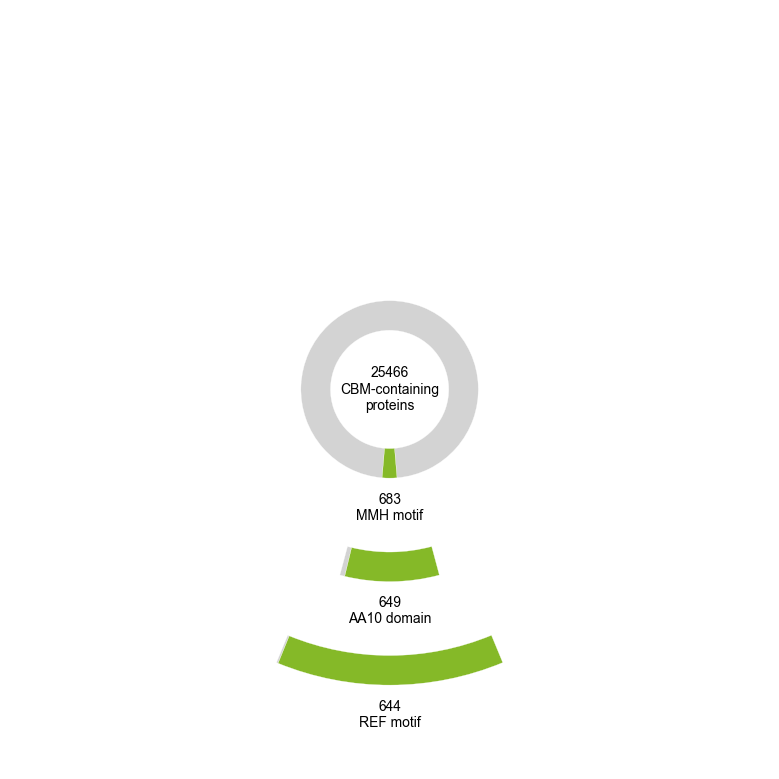

In [226]:
fig, ax = plt.subplots(dpi=200)
mid_angle = 30
outer_angle = 45
size = 0.1
inner_vals = [360*24783/25466, 360*683/25466]
# mid_vals = [24817, 34, 649]
# outer_vals = [24851, 5, 644]
mid_vals = np.array([360-mid_angle, mid_angle*34/683, mid_angle*649/683])
outer_vals = [360-outer_angle, outer_angle*5/649, outer_angle*644/649]

inner_colors = ['lightgray', '#85b928']
mid_colors = ['w', 'lightgray', '#85b928']
outer_colors = ['w', 'lightgray', '#85b928']
# inner text
plt.rcParams["font.family"] = "arial"
plt.text(0,0,'25466\nCBM-containing\nproteins', fontsize=5, ha='center', va='center')
# inner
ax.pie(inner_vals, radius=0.3, colors=inner_colors, startangle= -85.2,
       wedgeprops=dict(width=size, edgecolor='w', linewidth=0.1))
plt.text(0,-.4,'683\nMMH motif', fontsize=5, ha='center', va='center')
# mid
ax.pie(mid_vals, radius=0.65, colors=mid_colors, startangle= -90+mid_angle/2,
       wedgeprops=dict(width=size, edgecolor='w', linewidth=0.1))
plt.text(0,-.75,'649\nAA10 domain', fontsize=5, ha='center', va='center')
# outer
ax.pie(outer_vals, radius=1, colors=outer_colors, startangle= -90+outer_angle/2,
       wedgeprops=dict(width=size, edgecolor='w', linewidth=0.1))
plt.text(0,-1.1,'644\nREF motif', fontsize=5, ha='center', va='center')

plt.savefig('../Data/06-structure_analysis/Pie_chart.svg', format='svg')

## Alphafold

In [38]:
# rename the files in the structures directory
for file in os.listdir("../05-structures"):
    if file.endswith(".pdb") or file.endswith(".json"):
        # get the uniprot id from the file name
        uniprot_id = file.split("-")[1]
        extension = file.split(".")[-1]
        # rename the file
        if extension == "pdb":
            os.rename(os.path.join("../05-structures", file), os.path.join("../05-structures", f"{uniprot_id}_AFDB.pdb"))
        elif extension == "json":
            os.rename(os.path.join("../05-structures", file), os.path.join("../05-structures", f"{uniprot_id}_AFDB_PAE.json"))

In [39]:
struc_list = [f.split('_')[0] for f in os.listdir('../05-structures/') if f.endswith('.pdb')]
print(f"number of structures: {len(struc_list)}")
# Check which sequences are not in the structures directory
ids_not_in_structures = [i for i in uniprot_ids if i not in struc_list]
print(f"number of sequences not in the structures directory: {len(ids_not_in_structures)}")

number of structures: 501
number of sequences not in the structures directory: 212


In [ ]:
# Chenck which MMH-containing non-AA10 are in the structures directory
structures_MMH_noAA10 = [i for i in accessions_MMH_noAA10 if i in struc_list]
print(f"number of structures with MMH non-AA10: {len(structures_MMH_noAA10)}")

number of structures with MMH non-AA10: 42


In [56]:
to_predict_noAA10 = [i for i in accessions_MMH_noAA10 if i not in struc_list]
print(f"number of sequences to predict: {len(to_predict_noAA10)}")

number of sequences to predict: 18


In [44]:
# Retrieve the sequences that are not in the structures directory
matches_full_to_predict = [rec for rec in matches_full if rec.id.split("|")[0] in ids_not_in_structures]
print(f"number of sequences to predict: {len(matches_full_to_predict)}")
# make a directory to store the sequences
if not os.path.exists("../05-structures/fastas_to_predict"):
    os.makedirs("../05-structures/fastas_to_predict")
# Write the sequences to single fasta files
for rec in matches_full_to_predict:
    SeqIO.write(rec, f"../05-structures/fastas_to_predict/{rec.id.split('|')[0]}.fa", "fasta")


number of sequences to predict: 212


In [60]:
# Retrieve the sequences that are not in the structures directory
matches_full_to_predict_noAA10 = [rec for rec in matches_full if rec.id.split("|")[0] in to_predict_noAA10]
print(f"number of sequences to predict: {len(matches_full_to_predict_noAA10)}")
# make a directory to store the sequences
if not os.path.exists("../05-structures/fastas_to_predict_noAA10"):
    os.makedirs("../05-structures/fastas_to_predict_noAA10")
# Write the sequences to single fasta files
for rec in matches_full_to_predict_noAA10:
    SeqIO.write(rec, f"../05-structures/fastas_to_predict_noAA10/{rec.id.split('|')[0]}.fasta", "fasta")


number of sequences to predict: 18


## AA10 subset

In [14]:
# find the same motif but now for the file /Subset_AA10_CBM2/aa10_cbm2_h1_mafft.fas
recs = list(SeqIO.parse("./Subset_AA10_CBM2/aa10_cbm2_h1_mafft.fas", "fasta"))
print(f"number of sequences read: {len(recs)}")

sequences = SeqIO.parse("./Subset_AA10_CBM2/aa10_cbm2_h1_mafft.fas", "fasta")
matches_subset = []

for seq_record in sequences:
    sequence = str(seq_record.seq)
    if motif_pattern.search(sequence):
        matches_subset.append(seq_record)

SeqIO.write(matches_subset, "aa10_cbm2_h1_mafft_motif.fa", "fasta")
print(f"number of sequences with the motif: {len(matches_subset)}")
print(f"sequences with the motif written to: aa10_cbm2_h1_mafft_motif.fa")


number of sequences read: 483
number of sequences with the motif: 167
sequences with the motif written to: aa10_cbm2_h1_mafft_motif.fa


In [17]:
accession_list = []
listpath = './accessions_MMH_noAA10.txt'  # Path to the file containing the list of accessions
with open(listpath, 'r') as f:
    for line in f:
        accession = line.strip()
        if accession:
            accession_list.append(accession)
print(f"Number of accessions: {len(accession_list)}")

# Read the TSV file
tsv_path = './MMH_dbcan_ranges.tsv'  # Path to the TSV file
df = pd.read_csv(tsv_path, sep='\t').set_index('uniprot')

# load the PDB files
pdbdir = '../05-structures'  # Directory where the PDB files are located
pdbs_list = os.listdir(pdbdir)
loadpdbs = [pdb for pdb in pdbs_list if pdb.endswith('.pdb') and pdb.split('_')[0] in accession_list]

Number of accessions: 60


In [19]:
for l in loadpdbs:
    print(l.split('_')[0])

A0A2W2C8Z9
A0A8J3W6H5
A0A919HIY4
A0A4R4T1E0
A0SGK1
A0SGK0
A0A9E5S1C5
A0A2Z3V0Y7
A0AAT9HKG3
A0A1N6S457
A0SGJ6
A0SGJ7
A0A852V6J6
A0A1G4SCK8
A0A5B9YDT5
A0A0C2ZMV9
A0A1I3ZA19
A0A919R3Z2
A0A1A5PEJ3
A0A7W9IJN7
A0AAU1AR00
A0A841D042
A0A919GDD7
A0A2P8I1Y2
A0A177HRM1
A0A238X701
A0A161LNA8
A0A3D0QQI1
A0A317DD42
A0A4R4RBH4
A0A7Z0Q2K9
A0A239BC39
A0A964Q5W4
A0A2C9ZMF8
A0A5D0T6V0
A0A8G1MZR7
A0A4U3M952
A0SGK2
A0A917VHU9
A0A7K2LVM1
A0A1C4S8W3
A0A136PIB4
A0A8J3T5M3
A0A3A9TC94
A0A4R4S909
A0A8J3N5H7
A0A8J3WEQ3
A0A1H2UGA1
A0AAU6E611
A0AAU5DQH4
C3UVM5
W9H1S5
A0A7C9P2B5
A0AA90R2S6
D2BFT4
A0A367FGZ3
A0A8J3SYF7
A0SGJ8
A0SGJ9
A0A2W2C5N1
